In [1]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchvision import transforms

from rolf.io import CreateTorchDataset, read_hdf5
from rolf.tools.toml_reader import ReadConfig
from rolf.training.training import TrainModule, train_model

In [2]:
config = ReadConfig("../configs/resnet18.toml")
train_config = config.training()

In [3]:
train_config

{'paths': {'data': PosixPath('../data/galaxy_data/all'),
  'model': PosixPath('../build/checkpoints')},
 'mode': {'verbose': True, 'gpu': True},
 'parameters': {'save_name': 'ResNet16_prelu_PreAct',
  'batch_size': 20,
  'epochs': 10,
  'loss_func': 'mse'},
 'model_name': 'ResNet',
 'net_hyperparams': {'num_classes': 4,
  'hidden_channels': [16, 32, 64, 128],
  'block_groups': [4, 4, 4, 4],
  'block_name': 'PreActBlock',
  'activation_name': 'mish'},
 'optimizer': 'SGD',
 'opt_hyperparams': {'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001},
 'save_name': 'ResNet16_prelu_PreAct',
 'batch_size': 20,
 'epochs': 10}

In [4]:
tm = TrainModule(
    model_name=train_config["model_name"],
    model_hparams=train_config["net_hyperparams"],
    optimizer_name=train_config["optimizer"],
    optimizer_hparams=train_config["opt_hyperparams"],
)

{'num_classes': 4, 'hidden_channels': [16, 32, 64, 128], 'block_groups': [4, 4, 4, 4], 'activation_name': 'mish', 'activation': <class 'torch.nn.modules.activation.Mish'>, 'block_type': <class 'rolf.architecture.blocks.PreActBlock'>}


In [5]:
data = read_hdf5("../data/galaxy_data_h5.h5")

In [6]:
data.columns

<TableColumns names=('index','img','RA','DEC','source','filepath','label','split')>

In [8]:
data_mean = (data["img"] / data["img"].max()).mean(axis=(0, 1, 2))
data_std = (data["img"] / data["img"].max()).std(axis=(0, 1, 2))

data_mean, data_std

(0.0004965368361328688, 0.014213577024571834)

In [9]:
train_transform = transforms.Normalize(data_mean, data_std)

In [10]:
def _get_split(split):
    temp = data[["filepath", "label"]][data["split"] == split]
    df = pd.DataFrame({"filepath": temp["filepath"], "label": temp["label"]})
    return df


train = _get_split("train")
test = _get_split("test")
valid = _get_split("valid")

In [11]:
img_dir = train_config["paths"]["data"]

train_set = CreateTorchDataset(
    train["label"].to_numpy(),
    train["filepath"].to_numpy(),
    img_dir=img_dir,
)
test_set = CreateTorchDataset(
    test["label"].to_numpy(), test["filepath"].to_numpy(), img_dir=img_dir
)
val_set = CreateTorchDataset(
    valid["label"].to_numpy(),
    valid["filepath"].to_numpy(),
    img_dir=img_dir,
)

train = None
test = None
valid = None

del train, test, valid

In [12]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=train_config["batch_size"],
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=4,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=train_config["batch_size"],
    shuffle=False,
    drop_last=False,
    num_workers=4,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=train_config["batch_size"],
    shuffle=False,
    drop_last=False,
    num_workers=4,
)

In [13]:
model, result, trainer = train_model(
    train_config["model_name"],
    train_loader,
    val_loader,
    test_loader,
    checkpoint_path=train_config["paths"]["model"],
    epochs=train_config["epochs"],
    save_name=train_config["save_name"],
    model_hparams=train_config["net_hyperparams"],
    optimizer_name=train_config["optimizer"],
    optimizer_hparams=train_config["opt_hyperparams"],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'num_classes': 4, 'hidden_channels': [16, 32, 64, 128], 'block_groups': [4, 4, 4, 4], 'activation_name': 'mish', 'activation': <class 'torch.nn.modules.activation.Mish'>, 'block_type': <class 'rolf.architecture.blocks.PreActBlock'>}



  | Name        | Type             | Params | Mode  | In sizes         | Out sizes
----------------------------------------------------------------------------------------
0 | model       | ResNet           | 1.5 M  | train | [1, 1, 300, 300] | [1, 4]   
1 | loss_module | CrossEntropyLoss | 0      | train | ?                | ?        
----------------------------------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.941     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'num_classes': 4, 'hidden_channels': [16, 32, 64, 128], 'block_groups': [4, 4, 4, 4], 'activation_name': 'mish', 'activation': <class 'torch.nn.modules.activation.Mish'>, 'block_type': <class 'rolf.architecture.blocks.PreActBlock'>}


Testing: |                                                                                                    …

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

In [14]:
result

{'test': 0.5299999713897705, 'val': 0.5400000214576721}

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

test_img = list(iter(test_loader))

In [15]:
model = TrainModule.load_from_checkpoint(
    "../build/checkpoints/ResNet16_prelu_PreAct/lightning_logs/version_2/checkpoints/epoch=112-step=9831.ckpt"
)
pred = model(test_img[0][0].to(device))

{'num_classes': 4, 'hidden_channels': [16, 32, 64, 128], 'block_groups': [4, 4, 4, 4], 'activation_name': 'mish', 'activation': <class 'torch.nn.modules.activation.Mish'>, 'block_type': <class 'rolf.architecture.blocks.PreActBlock'>}


In [16]:
with torch.no_grad():
    preds = np.argmax(pred.to("cpu"), axis=1)

In [17]:
(test_img[0][1] == preds).sum() / len(preds)

tensor(0.7500)

In [18]:
test_img[0]

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [40]:
for im in test_img[0][0][:2]:
    print(im.squeeze())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


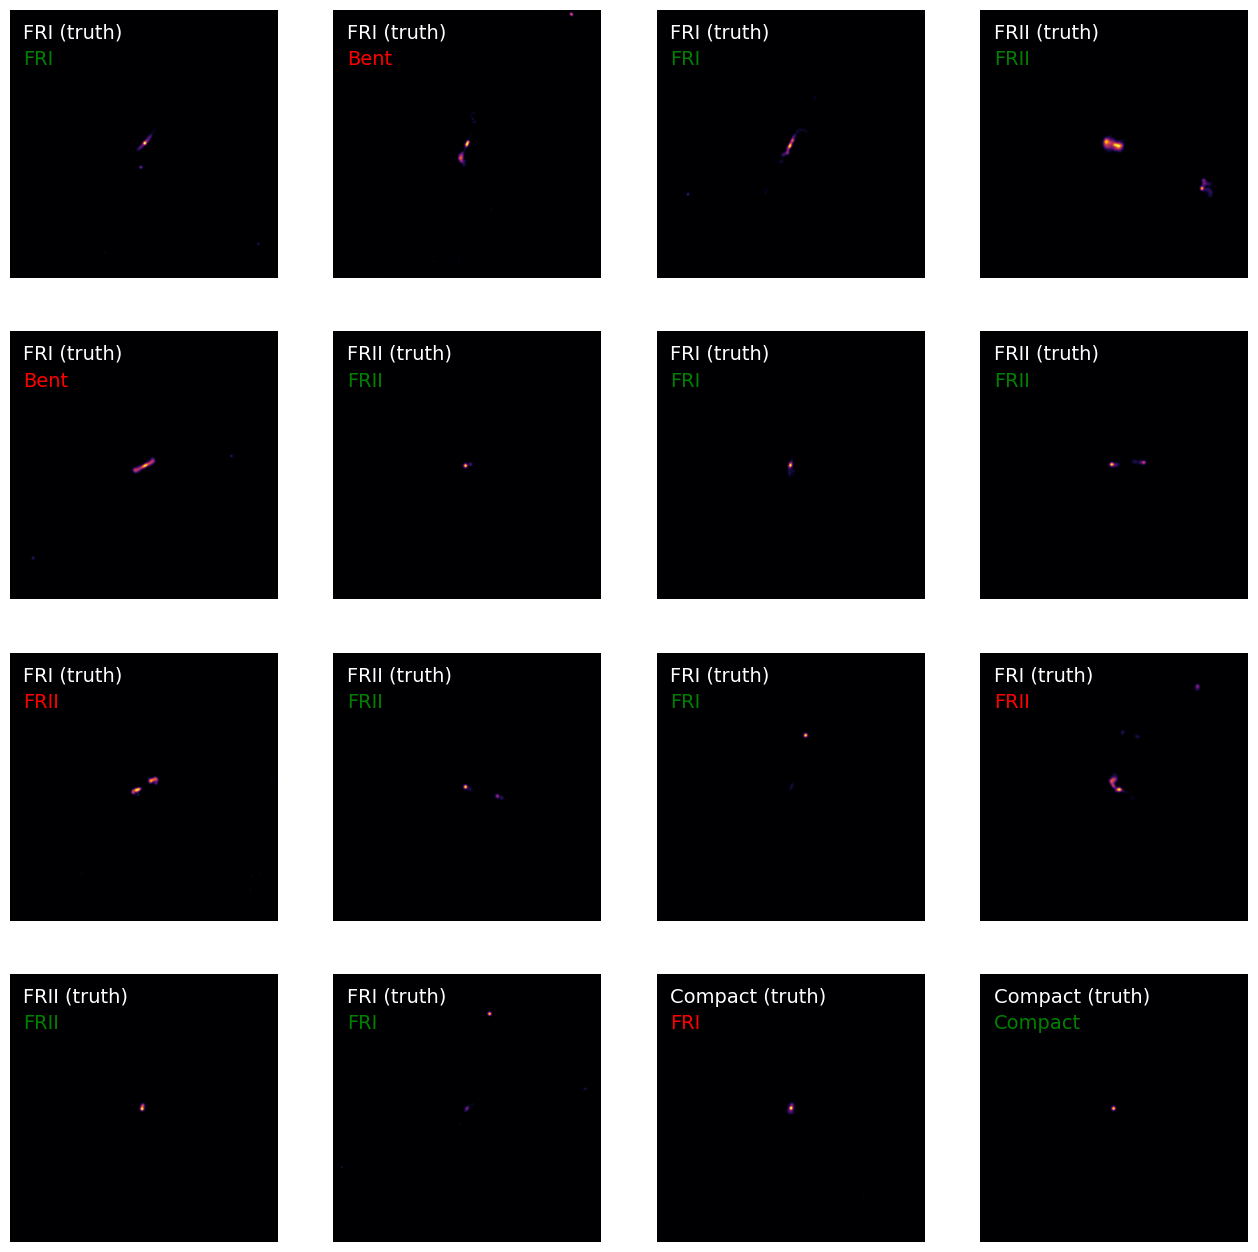

In [60]:
labels_map = {
    0: "FRI",
    1: "FRII",
    2: "Compact",
    3: "Bent",
}

if len(test_img[0]) > 16:
    images = test_img[0][0][:16]
    labels = test_img[0][1][:16]
    labels_pred = preds[:16]
else:
    images = test_img[0][0]
    labels = test_img[0][1]
    labels_pred = preds

figure, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.flatten()

for ax, img, label, label_pred in zip(axs, images, labels, labels_pred):
    img = img.squeeze()
    label = label.item()
    label_pred = label_pred.item()

    correct = label_pred == label

    ax.text(
        0.05,
        0.95,
        f"{labels_map[label]} (truth)",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        color="white",
        fontsize=14,
    )
    ax.text(
        0.05,
        0.85,
        labels_map[label_pred],
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        color="green" if correct else "red",
        fontsize=14,
    )
    ax.axis("off")
    ax.imshow(img, cmap="inferno")

plt.show()